## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This fully quantum approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions.

This implementation uses aer_simulator_statevector.

## Implementation (statevector simulation)

In [ ]:
# INSTALATION INSTRUCTIONS

# For linux 64-bit systems,
#uname -a

# Conda quick installation
#mkdir -p ~/miniconda3
#wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
#bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
#rm ~/miniconda3/miniconda.sh

# Create enviroment with conda
#conda create -n myenv python=3.10
#conda activate myenv
#pip install qiskit==1.4.3 qiskit-machine-learning==0.8.2 'qiskit-machine-learning[sparse]' tensorflow matplotlib pylatexenc ipykernel
# IMPORTANT: Make sure you are on 3.10
# May need to restart the kernel after instalation

In [58]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import random_statevector, Statevector, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorEstimator
from qiskit.visualization import plot_histogram

from qiskit_machine_learning.neural_networks import EstimatorQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient

import numpy as np
import tensorflow as tf
import copy
import matplotlib.pyplot as plt
import time
import os

In [ ]:
# Number of qubits ## 4:4, 8:, 16:
N_QUBITS = 16

SEED = 1
np.random.seed(SEED)

draw_circuits = 0
draw_prob = 0
print_progress = 1

In [60]:
# Create real data sample circuit
def generate_real_circuit():
    # sv = random_statevector(2**N_QUBITS, seed=SEED)
    # qc = QuantumCircuit(N_QUBITS)
    # qc.prepare_state(sv, qc.qubits, normalize=True)

    qc = QuantumCircuit(N_QUBITS)
    qc.h(range(N_QUBITS-1))
    qc.cx(N_QUBITS-2, N_QUBITS-1)
    return qc


real_circuit = generate_real_circuit()


if draw_circuits:
    display(real_circuit.decompose(reps=5).draw('mpl'))

if draw_prob:
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**N_QUBITS):
                key = format(n, 'b').zfill(N_QUBITS)
                if key not in dict.keys():
                    dict[key] = 0.0

    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    prepare_dicts([real_prob_dict])
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1.set_title("Real data distribution")
    plot_histogram(real_prob_dict, ax=ax1)

In [61]:
# Create generator
def generate_generator():
    qc = RealAmplitudes(N_QUBITS,
                        reps=2, # Number of layers
                        parameter_prefix='θ_g',
                        name='Generator')
    return qc


generator = generate_generator()


if draw_circuits:
    display(generator.decompose().draw('mpl'))

In [62]:
# Initialize generator parameters
N_GPARAMS = generator.num_parameters

init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_GPARAMS,))

if draw_prob:
    init_gen_circuit = generator.assign_parameters(init_gen_params)
    init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial distribution")
    plot_histogram(init_prob_dict, ax=ax1)

N_GPARAMS

96

In [63]:
# Create discriminator
def generate_discriminator():
    disc_weights = ParameterVector('θ_d', 3*(N_QUBITS+1))
    qc = QuantumCircuit(N_QUBITS, name="Discriminator")
    param_index = 0

    qc.barrier()

    for q in range(N_QUBITS):
        qc.h(q)
        qc.rx(disc_weights[param_index], q); param_index += 1
        qc.ry(disc_weights[param_index], q); param_index += 1
        qc.rz(disc_weights[param_index], q); param_index += 1

    for i in range(N_QUBITS - 1):
        qc.cx(i, N_QUBITS - 1)

    qc.rx(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.ry(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.rz(disc_weights[param_index], N_QUBITS-1); param_index += 1
    
    return qc


discriminator = generate_discriminator()


if draw_circuits:
    display(discriminator.draw('mpl'))
    

In [64]:
# Initialize generator parameters
N_DPARAMS = discriminator.num_parameters

init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_DPARAMS,))

N_DPARAMS

99

In [65]:
# Set up training quantum circuits
def generate_training_circuits():
    # Connect real data and discriminator
    real_disc_circuit = QuantumCircuit(N_QUBITS)
    real_disc_circuit.compose(real_circuit, inplace=True)
    real_disc_circuit.compose(discriminator, inplace=True)

    # Connect generator and discriminator
    gen_disc_circuit = QuantumCircuit(N_QUBITS)
    gen_disc_circuit.compose(generator, inplace=True)
    gen_disc_circuit.compose(discriminator, inplace=True)

    # Use EstimatorQNN to compile the circuit and handle gradient calculation
    estimator = StatevectorEstimator()

    gradient = ParamShiftEstimatorGradient(estimator=estimator)

    H1 = SparsePauliOp.from_list([("Z" + "I"*(N_QUBITS-1), 1.0)])

    # specify QNN to update generator parameters
    gen_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                        input_params=gen_disc_circuit.parameters[:N_DPARAMS], # fixed parameters (discriminator parameters)
                        weight_params=gen_disc_circuit.parameters[N_DPARAMS:], # parameters to update (generator parameters)
                        estimator=estimator,
                        observables=[H1],
                        gradient=gradient,
                        default_precision=0.0
                        )

    # specify QNN to update discriminator parameters regarding to fake data
    disc_fake_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                            input_params=gen_disc_circuit.parameters[N_DPARAMS:], # fixed parameters (generator parameters)
                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                            estimator=estimator,
                            observables=[H1],
                            gradient=gradient,
                            default_precision=0.0
                            )

    # specify QNN to update discriminator parameters regarding to real data
    disc_real_qnn = EstimatorQNN(circuit=real_disc_circuit,
                            input_params=[], # no input parameters
                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                            estimator=estimator,
                            observables=[H1],
                            gradient=gradient,
                            default_precision=0.0
                            )
    
    return gen_qnn, disc_fake_qnn, disc_real_qnn

gen_qnn, disc_fake_qnn, disc_real_qnn = generate_training_circuits()

In [66]:
# Initialize Adam optimizer from Keras (TensorFlow)
def generate_optimizers(reset, optimizers_data_folder, gen_params, disc_params):
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    # Create optimizer training state checkpoints
    ckpt = tf.train.Checkpoint(
        generator_vars=gen_params,
        discriminator_vars=disc_params,
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer
    )
    ckpt_manager = tf.train.CheckpointManager(ckpt, optimizers_data_folder, max_to_keep=3)
    if reset:
        ckpt_manager.save()
    else:
        ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()

    return generator_optimizer, discriminator_optimizer, ckpt_manager

In [67]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [68]:
def manage_files(data_folder_name="data", implementation_name="fullyq", training_data_file_name='training_data', parameter_data_file_name='parameters', optimizers_data_folder_name='optimizer'):
    data_folder = data_folder_name + '/' + implementation_name + '/' + "sim" + '/' + 'q' + str(N_QUBITS) + '/' + 'seed' + str(SEED) + '/' 
    training_data_file = data_folder + training_data_file_name + '.txt'
    parameter_data_file = data_folder + parameter_data_file_name + '.txt'
    optimizers_data_folder = data_folder + optimizers_data_folder_name + '/'

    # Create data folder if it does not exist
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    return training_data_file, parameter_data_file, optimizers_data_folder
    

In [69]:
def initialize_parameters(reset, training_data_file, parameter_data_file):
    if reset == 1:
        current_epoch = 0
        gloss, dloss, kl_div = [], [], []

        np.random.seed(SEED)
        init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_GPARAMS,))
        init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_DPARAMS,))
        gen_params = tf.Variable(init_gen_params)
        disc_params = tf.Variable(init_disc_params)
        best_gen_params = tf.Variable(init_gen_params)

        # Reset data files
        with open(training_data_file, 'w') as file:
            pass
        with open(parameter_data_file, 'w') as file:
            file.write(str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
            
    else:
        # Load training data
        try:
            with open(training_data_file) as f:
                lines = f.read().splitlines()
        except FileNotFoundError:
            print("Training data file not found. Resetting parameters.")
            return initialize_parameters(1, training_data_file, parameter_data_file)
        current_epoch = len(lines)
        gloss, dloss, kl_div = [], [], []
        for line in lines:
            line_data = line.split(";")
            if len(line_data) != 4:
                raise Exception("ERROR: Wrong data length in training_data.txt file in line:", line, ". Please, reset data.")
            gloss.append(np.float64(line_data[1]))
            dloss.append(np.float64(line_data[2]))
            kl_div.append(np.float64(line_data[3]))

        # Load parameters
        with open(parameter_data_file) as f: # Load parameters
            line = f.readline()
        line_data = line.split(";")
        if len(line_data) != 5:
            raise Exception("ERROR: Wrong number of parameters in parameters.txt file. Please, reset data.")
        init_gen_params = np.array(eval(line_data[0])).astype(float)
        init_disc_params = np.array(eval(line_data[1])).astype(float)
        gen_params = tf.Variable(np.array(eval(line_data[2])).astype(float))
        disc_params = tf.Variable(np.array(eval(line_data[3])).astype(float))
        best_gen_params = tf.Variable(np.array(eval(line_data[4])).astype(float))

    return current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params

In [70]:
# Training

#--- Initialize parameters ---#
max_epoch = 300
reset = 0 # Reset data

training_data_file, parameter_data_file, optimizers_data_folder = manage_files()

current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params = initialize_parameters(reset, training_data_file, parameter_data_file)


#--- Create and load optimizer states ---#
generator_optimizer, discriminator_optimizer, optimizers_ckpt_manager = generate_optimizers(reset, optimizers_data_folder, gen_params, disc_params)


D_STEPS = 1
G_STEPS = 1
C_STEPS = 1
if print_progress:
    TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
    print(TABLE_HEADERS)
file = open(training_data_file,'a')
start_time = time.time()

#--- Training loop ---#
try: # In case of interruption
    for epoch in range(current_epoch, max_epoch+1):

        #--- Quantum discriminator parameter updates ---#
        for disc_train_step in range(D_STEPS):
            # Calculate discriminator cost
            if (disc_train_step % D_STEPS == 0) and (epoch % C_STEPS == 0):
                value_dcost_fake = disc_fake_qnn.forward(gen_params, disc_params)[0,0]
                value_dcost_real = disc_real_qnn.forward([], disc_params)[0,0]
                disc_loss = ((value_dcost_real - value_dcost_fake)-2)/4
                dloss.append(disc_loss)

            # Caltulate discriminator gradient
            grad_dcost_fake = disc_fake_qnn.backward(gen_params, disc_params)[1][0,0]
            grad_dcost_real = disc_real_qnn.backward([], disc_params)[1][0,0]
            grad_dcost = grad_dcost_real - grad_dcost_fake
            grad_dcost = tf.convert_to_tensor(grad_dcost)
            
            # Update discriminator parameters
            discriminator_optimizer.apply_gradients(zip([grad_dcost], [disc_params]))

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(G_STEPS):
            # Calculate generator cost
            if (gen_train_step % G_STEPS == 0) and (epoch % C_STEPS == 0):
                value_gcost = gen_qnn.forward(disc_params, gen_params)[0,0]
                gen_loss = (value_gcost-1)/2
                gloss.append(gen_loss)

            # Calculate generator gradient
            grad_gcost = gen_qnn.backward(disc_params, gen_params)[1][0,0]
            grad_gcost = tf.convert_to_tensor(grad_gcost)

            # Update generator parameters
            generator_optimizer.apply_gradients(zip([grad_gcost], [gen_params]))

        #--- Track KL and save best performing generator weights ---#
        gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy())
        gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict() # Retrieve probability distribution of generator with current parameters
        
        real_prob_dict = Statevector(real_circuit).probabilities_dict() # Retrieve real data probability distribution
        
        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            best_gen_params = copy.deepcopy(gen_params) # New best

        #--- Save progress in file ---#
        file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

        #--- Print progress ---#
        if print_progress and (epoch % 1 == 0):
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
            
#--- Save parameters and optimizer states data ---#
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(init_gen_params.tolist()) + ";" + str(init_disc_params.tolist()) + ";" + str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
    file.close()

    optimizers_ckpt_manager.save()
    
print("Training complete.")


Training data file not found. Resetting parameters.
Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |


MemoryError: Unable to allocate 64.0 GiB for an array with shape (4294967296,) and data type complex128

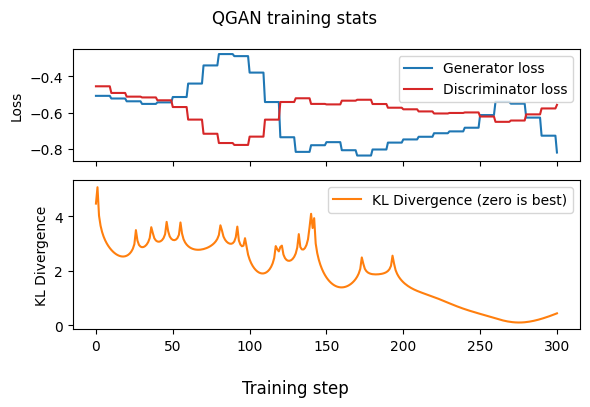

In [ ]:
draw_results = 1
if draw_results:
        if C_STEPS > 1: # For when C_STEPS > 1, implemented for creating less jobs in real hardware
                def prepare_loss_data(l):
                        ax = [0]
                        data =  [l[0]]
                        for i in range(1, len(l)):
                                if l[i] != l[i - 1]:
                                        ax.append(i)
                                        data.append(l[i])
                        return ax, data
                
                # Load saved data
                training_data_file, parameter_data_file, optimizers_data_folder = manage_files()
                current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params = initialize_parameters(0, training_data_file, parameter_data_file)

                gloss_ax, gloss_data = prepare_loss_data(gloss)
                dloss_ax, dloss_data = prepare_loss_data(dloss)
        else:
                gloss_ax = range(len(gloss))
                dloss_ax = range(len(dloss))
                gloss_data = gloss
                dloss_data = dloss

        fig, (loss, kl) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
        fig.suptitle('QGAN training stats')
        fig.supxlabel('Training step')
        loss.plot(gloss_ax, gloss_data, label="Generator loss")
        loss.plot(dloss_ax, dloss_data, label="Discriminator loss", color="C3")
        loss.legend()
        loss.set(ylabel='Loss')
        kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)", color="C1")
        kl.set(ylabel='KL Divergence')
        kl.legend()
        fig.tight_layout()

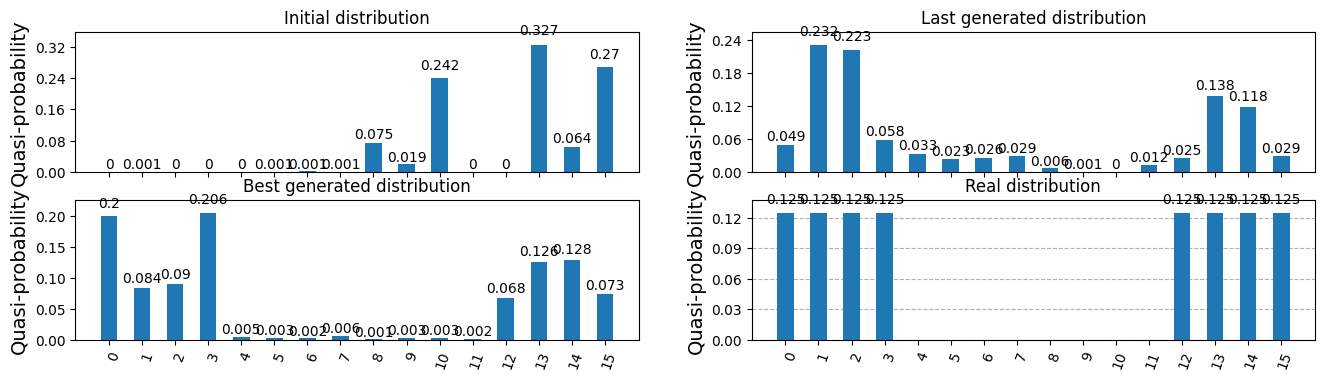

In [ ]:
# Create test circuit with new parameters
draw_results = 1
if draw_results:
    dict1 = Statevector(generator.assign_parameters(init_gen_params)).probabilities_dict()
    dict2 = Statevector(generator.assign_parameters(gen_params.numpy())).probabilities_dict()
    dict3 = Statevector(generator.assign_parameters(best_gen_params.numpy())).probabilities_dict()
    dict4 = Statevector(real_circuit).probabilities_dict()
    
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**N_QUBITS):
                key = format(n, 'b').zfill(N_QUBITS)
                if key not in dict.keys():
                    dict[n] = 0.0
                else:
                    dict[n] = dict[key]
                    del dict[key]
        

    prepare_dicts([dict1, dict2, dict3, dict4])

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(16,4))
    ax1.set_title("Initial distribution")
    ax2.set_title("Last generated distribution")
    ax3.set_title("Best generated distribution")
    ax4.set_title("Real distribution")
    plot_histogram(dict1, ax=ax1)
    plot_histogram(dict2, ax=ax2)
    plot_histogram(dict3, ax=ax3)
    plot_histogram(dict4, ax=ax4)
    #fig.tight_layout()